In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
%matplotlib notebook 

# Calculate Hex Positions

<IPython.core.display.Javascript object>


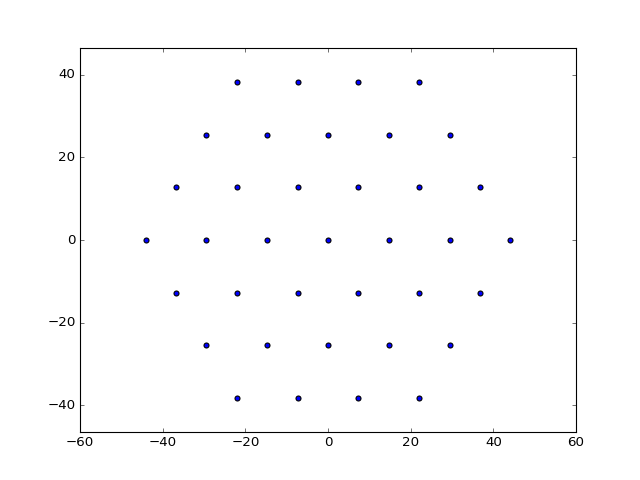

In [2]:
Separation = 14.7
precisionFactor = 1000000        
hexNum = 4

#Calculating Positions:
positions = []
for row in range(hexNum-1,-(hexNum),-1):
    for col in range(2*hexNum-abs(row)-1):
        xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*Separation;
        yPos = row*Separation*3**.5/2;
        positions.append([xPos, yPos, 0])
positions = np.array(positions)

plt.figure(1)
plt.scatter(positions[:,0], positions[:,1])
plt.axis('equal');

# Calculate Unique Baselines

In [4]:
#Calculating Baselines    
nAntennas = len(positions)
blVectors = []
blPairs = []
for ant1 in range(nAntennas):
    for ant2 in range(ant1+1,nAntennas):
        delta = np.array([int(np.round(precisionFactor*(positions[ant1][i]-positions[ant2][i]))) for i in range(3)])
        if delta[1] > 0 or (delta[1] == 0 and delta[0] > 0): 
            blVectors.append(tuple(delta))
            blPairs.append((ant1, ant2))
        else: 
            blVectors.append(tuple(-delta))
            blPairs.append((ant2, ant1))
        
#Calculating Unique Baselines
ublDict = {}
for b in range(len(blVectors)):
    if ublDict.has_key(blVectors[b]): ublDict[blVectors[b]].append(blPairs[b])
    else: ublDict[blVectors[b]] = [blPairs[b]]
ublIndexDict = {antPair: i for i,antPairs in enumerate(ublDict.values()) for antPair in antPairs }
ublVectors = np.array([positions[antList[0][0]]-positions[antList[0][1]] for antList in ublDict.values()])
print "With", len(positions), "antennas there are", len(ublDict.items()), "unique baselines."

nant, nbl, nubl = len(positions), len(blPairs), len(ublVectors)

With 37 antennas there are 63 unique baselines.


# Generate Fake Visibilities

In [5]:
noiseLevel = .00
signalLevel = 1
gainLevel = .5
phaseLevel = .1 #radians

gains = np.exp(gainLevel*np.random.randn(nant) + 1.0j * phaseLevel*np.random.randn(nant))
#gains *= np.exp(-1.0j * np.mean(np.angle(gains))) / np.mean(np.abs(gains))

trueVis = signalLevel*(np.random.randn(nubl) + 1.0j*np.random.randn(nubl))
noise = noiseLevel*(np.random.randn(nbl) + 1.0j*np.random.randn(nbl))

obsVis = [gains[ant1] * np.conj(gains[ant2]) * trueVis[ublIndexDict[(ant1,ant2)]] for (ant1,ant2) in blPairs]
noiselessVis = np.array(obsVis)
obsVis = np.array(obsVis) + noise

# plt.figure()
# plt.plot(np.real(obsVis), np.imag(obsVis),'.')

# Degeneracy Projection Matrix

In [6]:
def DegeneracyProjectionMatrices(AtA):
    #Find orthonormal vectors that span the null-space
    evals, evecs = np.linalg.eigh(AtA)
    zeroEVecs = (evecs[:,evals < 1e-12*np.max(evals)]).T
#     for i in range(len(zeroEVecs)):
#         for j in range(i+1,len(zeroEVecs)):
#             zeroEVecs[j,:] -= zeroEVecs[i,:].dot(zeroEVecs[j,:]) * zeroEVecs[i,:]
#             zeroEVecs[j,:] /= np.linalg.norm(zeroEVecs[j,:])
    
    Proj = np.eye(len(zeroEVecs[0,:])) - zeroEVecs.T.dot(zeroEVecs)
    IMinusProj = np.eye(len(zeroEVecs[0,:])) - Proj
    return Proj, IMinusProj

# Run Logcal

In [7]:
Acoeffs, Bcoeffs, rowIndices, colIndices = [np.zeros(nbl*3) for i in range(4)]
for n,(ant1,ant2) in enumerate(blPairs):
    rowIndices[3*n:3*n+3] = n
    colIndices[3*n:3*n+3] = [ant1, ant2, nant + ublIndexDict[(ant1,ant2)]]
    Acoeffs[3*n:3*n+3] = [1.0, 1.0, 1.0]
    Bcoeffs[3*n:3*n+3] = [1.0, -1.0, 1.0]

logcalA = csr_matrix((Acoeffs,(rowIndices,colIndices)), shape=(nbl, nant + nubl))
logcalB = csr_matrix((Bcoeffs,(rowIndices,colIndices)), shape=(nbl, nant + nubl))

AtA = (logcalA.conj().T.dot(logcalA)).toarray()
BtB = (logcalB.conj().T.dot(logcalB)).toarray()

AProj, IMinusAProj = DegeneracyProjectionMatrices(AtA)
BProj, IMinusBProj = DegeneracyProjectionMatrices(BtB)

xReal = (np.linalg.pinv(AtA)).dot(logcalA.conj().T.dot(np.real(np.log(obsVis))))
xImag = (np.linalg.pinv(BtB)).dot(logcalB.conj().T.dot(np.imag(np.log(obsVis))))
xRealTrue = np.real(np.log(np.append(gains, trueVis)))
xImagTrue = np.imag(np.log(np.append(gains, trueVis)))
xReal = AProj.dot(xReal) + IMinusAProj.dot(xRealTrue)
xImag = BProj.dot(xImag) + IMinusBProj.dot(xImagTrue)

xHat = np.exp(xReal + 1.0j*xImag)
logcalGainSols, logcalVisSols = xHat[0:nant], xHat[nant:]
calVis = [obs / (logcalGainSols[ant1]*np.conj(logcalGainSols[ant2])) for (ant1,ant2),obs in zip(blPairs,obsVis)]

print 'Zero Eigenvalues: ', [np.sum(np.abs(np.linalg.eigvals(XtX)<1e-10)) for XtX in [AtA, BtB]]

Zero Eigenvalues:  [1, 3]


<IPython.core.display.Javascript object>


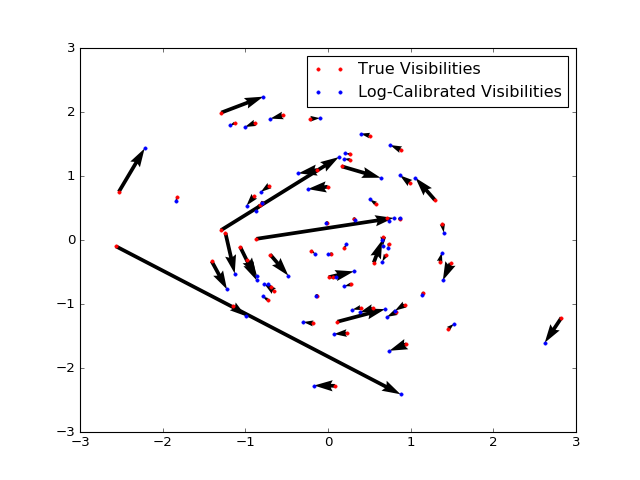

In [8]:
plt.figure()
plt.quiver(np.real(trueVis), np.imag(trueVis), np.real(logcalVisSols-trueVis), np.imag(logcalVisSols-trueVis),
           angles='xy', scale_units='xy', scale=1)
plt.plot(np.real(trueVis), np.imag(trueVis),'r.',label='True Visibilities')
plt.plot(np.real(logcalVisSols), np.imag(logcalVisSols),'b.',label='Log-Calibrated Visibilities')
plt.legend(loc='best')

#plt.figure()
#plt.plot(np.abs(trueVis), np.abs(logcalVisSols))
#plt.plot(np.angle(trueVis), np.angle(logcalVisSols),'.')
#plt.xlabel('Phase(True Visibility)'); plt.ylabel('Phase(Visibility Solution)')

# Now Run Lincal

$V_{ij}^\text{obs} \approx g_i g_j^* V_{ij}^\text{model}$

$\equiv (f_i + ih_i)(f_j-ih_j)(U_{ij}+iW_{ij})$

$\approx (f_{i0} + \Delta f_i + i h_i + i\Delta h_i) (f_{j0} + \Delta f_j - i h_j - i\Delta h_j)(U_{ij} + \Delta U_{ij0} + iW_{ij0} + i\Delta W_{ij}) $

Dropping 2nd order terms...

$V_{ij}^\text{obs} - g_{i0} g_{j0}^* V_{ij0}^\text{model} \approx (\Delta f_i + i\Delta h_i) g^*_{j0} V^\text{model}_{ij0} + (\Delta f_j - i\Delta h_j) g_{i0} V^\text{model}_{ij0} + g_{i0}g^*_{j0}(\Delta U_{ij} + i \Delta W_{ij})$

So the system of equations will be:

$\text{Re}(V_{ij}^\text{obs} - g_{i0} g_{j0}^* V_{ij0}^\text{model}) = \text{Re}(g^*_{j0} V^\text{model}_{ij0}) \Delta f_i - \text{Im}(g^*_{j0} V^\text{model}_{ij0}) \Delta h_i + \text{Re}(g_{i0} V^\text{model}_{ij0}) \Delta f_j + \text{Im}(g_{i0} V^\text{model}_{ij0}) \Delta h_j  + \text{Re}(g_{i0}g^*_{j0})\Delta U_{ij} - \text{Im}(g_{i0}g^*_{j0}) \Delta W_{ij}$

$\text{Im}(V_{ij}^\text{obs} - g_{i0} g_{j0}^* V_{ij0}^\text{model}) = \text{Im}(g^*_{j0} V^\text{model}_{ij0}) \Delta f_i + \text{Re}(g^*_{j0} V^\text{model}_{ij0}) \Delta h_i + \text{Im}(g_{i0} V^\text{model}_{ij0}) \Delta f_j - \text{Re}(g_{i0} V^\text{model}_{ij0}) \Delta h_j  + \text{Im}(g_{i0}g^*_{j0})\Delta U_{ij} + \text{Re}(g_{i0}g^*_{j0}) \Delta W_{ij}$

I'll index everything as follows: $\Delta f_0$, $\Delta h_0$, $\Delta f_1$, $\Delta h_1$, ... , $\Delta U_{\text{UBL 0}}$, $\Delta W_{\text{UBL 0}}$, $\Delta U_{\text{UBL 1}}$, $\Delta W_{\text{UBL 1}}$, ...

In [9]:
gainSols = logcalGainSols.copy()
visSols = logcalVisSols.copy()

allProj = []

for iteration in range(100):

    Acoeffs, rowIndices, colIndices = [np.zeros(nbl*12) for i in range(3)]
    for n,(ant1,ant2) in enumerate(blPairs):
        rowIndices[12*n:12*n+6] = 2*n
        rowIndices[12*n+6:12*n+12] = 2*n+1
        ublIndex = ublIndexDict[(ant1,ant2)]
        colIndices[12*n:12*n+6] = [2*ant1, 2*ant1+1, 2*ant2, 2*ant2+1, 2*nant+2*ublIndex, 2*nant+2*ublIndex+1]
        colIndices[12*n+6:12*n+12] = [2*ant1, 2*ant1+1, 2*ant2, 2*ant2+1, 2*nant+2*ublIndex, 2*nant+2*ublIndex+1]
        #Compute coefficients
        gi0V0 = gainSols[ant1] * visSols[ublIndex]
        gj0starV0 = np.conj(gainSols[ant2]) * visSols[ublIndex]
        gi0gj0star = gainSols[ant1] * np.conj(gainSols[ant2])
        Acoeffs[12*n:12*n+6] = [np.real(gj0starV0), -np.imag(gj0starV0), np.real(gi0V0), 
                                np.imag(gi0V0), np.real(gi0gj0star), -np.imag(gi0gj0star)]
        Acoeffs[12*n+6:12*n+12] = [np.imag(gj0starV0), np.real(gj0starV0), np.imag(gi0V0), 
                                   -np.real(gi0V0), np.imag(gi0gj0star), np.real(gi0gj0star)]

    A = csr_matrix((Acoeffs,(rowIndices,colIndices)), shape=(2*nbl, 2*nant + 2*nubl))
    AtA = (A.conj().T.dot(A)).toarray()

    modelObs = np.array([gainSols[ant1] * np.conj(gainSols[ant2]) * visSols[ublIndexDict[(ant1,ant2)]]  
                         for (ant1,ant2),obs in zip(blPairs,obsVis)])
    error = obsVis - modelObs
    y = np.dstack((np.real(error),np.imag(error))).flatten()
    xHat = np.linalg.pinv(AtA).dot(A.conj().T.dot(y))
    
    Proj, IMinusProj = DegeneracyProjectionMatrices(AtA)
    allProj.append(Proj) 
    xCurrent = np.dstack((np.real(np.append(gainSols, visSols)),np.imag(np.append(gainSols, visSols)))).flatten()
    xTrue = np.dstack((np.real(np.append(gains, trueVis)),np.imag(np.append(gains, trueVis)))).flatten()    

    xHat = Proj.dot(xHat) + IMinusProj.dot(xTrue - xCurrent) 
    
    updates = xHat[0::2] + 1.0j*xHat[1::2]
    alpha = 1
    gainSols += alpha*updates[0:nant]
    visSols += alpha*updates[nant:]

    modelObs = np.array([gainSols[ant1] * np.conj(gainSols[ant2]) * obs  for (ant1,ant2),obs in zip(blPairs,obsVis)])
    
    print 'Relative change in solutions:', np.linalg.norm(updates) / np.linalg.norm(np.append(gainSols,visSols))
    if np.linalg.norm(updates) / np.linalg.norm(np.append(gainSols,visSols)) < 1e-14: break

Relative change in solutions: 0.392127770032
Relative change in solutions: 0.0568161281958
Relative change in solutions: 0.00395447319322
Relative change in solutions: 1.63374898128e-05
Relative change in solutions: 1.36402976827e-10
Relative change in solutions: 7.6911504672e-17


# Phase/Amplitude Lincal

In [10]:
gainSols2 = logcalGainSols.copy()
visSols2 = logcalVisSols.copy()

allProj2 = []

for iteration in range(100):

    Acoeffs, rowIndices, colIndices = [np.zeros(nbl*12) for i in range(3)]
    for n,(ant1,ant2) in enumerate(blPairs):
        rowIndices[12*n:12*n+6] = 2*n
        rowIndices[12*n+6:12*n+12] = 2*n+1
        ublIndex = ublIndexDict[(ant1,ant2)]
        colIndices[12*n:12*n+6] = [2*ant1, 2*ant1+1, 2*ant2, 2*ant2+1, 2*nant+2*ublIndex, 2*nant+2*ublIndex+1]
        colIndices[12*n+6:12*n+12] = [2*ant1, 2*ant1+1, 2*ant2, 2*ant2+1, 2*nant+2*ublIndex, 2*nant+2*ublIndex+1]
        #Compute coefficients
        gi0gj0star = gainSols2[ant1] * np.conj(gainSols2[ant2])
        gi0gj0starVij0 = gi0gj0star * visSols[ublIndex]
        Acoeffs[12*n:12*n+6] = [np.real(gi0gj0starVij0), -np.imag(gi0gj0starVij0), np.real(gi0gj0starVij0), 
                                np.imag(gi0gj0starVij0), np.real(gi0gj0star), -np.imag(gi0gj0star)]
        Acoeffs[12*n+6:12*n+12] = [np.imag(gi0gj0starVij0), np.real(gi0gj0starVij0), np.imag(gi0gj0starVij0), 
                                   -np.real(gi0gj0starVij0), np.imag(gi0gj0star), np.real(gi0gj0star)]

    A = csr_matrix((Acoeffs,(rowIndices,colIndices)), shape=(2*nbl, 2*nant + 2*nubl))
    AtA = (A.conj().T.dot(A)).toarray()

    modelObs = np.array([gainSols2[ant1] * np.conj(gainSols2[ant2]) * visSols2[ublIndexDict[(ant1,ant2)]]  
                         for (ant1,ant2),obs in zip(blPairs,obsVis)])
    error = obsVis - modelObs
    y = np.dstack((np.real(error),np.imag(error))).flatten()
    xHat = np.linalg.pinv(AtA).dot(A.conj().T.dot(y))
    
    Proj, IMinusProj = DegeneracyProjectionMatrices(AtA)
    allProj2.append(Proj)
    deltaGains = gains/gainSols2
    deltaVis = trueVis - visSols2
    deltax = np.dstack((np.append(np.abs(np.log(deltaGains)),np.real(deltaVis)), 
                        np.append(np.angle(deltaGains), np.imag(deltaVis)))).flatten()
    xHat = Proj.dot(xHat) + IMinusProj.dot(deltax)                  
    updates = xHat[0::2] + 1.0j*xHat[1::2]
    
    gainSols2 *= (1.0+updates[0:nant])
    visSols2 += updates[nant:]
    modelObs = np.array([gainSols[ant1] * np.conj(gainSols[ant2]) * obs  for (ant1,ant2),obs in zip(blPairs,obsVis)])
    
    print 'Relative change in solutions:', np.linalg.norm(updates) / np.linalg.norm(np.append(gainSols2,visSols2))
    if np.linalg.norm(updates) / np.linalg.norm(np.append(gainSols2,visSols2)) < 1e-14: break

Relative change in solutions: 0.398701240156
Relative change in solutions: 0.0244428224673
Relative change in solutions: 0.00210282137423
Relative change in solutions: 0.000304847406007
Relative change in solutions: 4.26263303872e-05
Relative change in solutions: 5.92433903145e-06
Relative change in solutions: 8.22682820306e-07
Relative change in solutions: 1.14228267023e-07
Relative change in solutions: 1.58601618489e-08
Relative change in solutions: 2.20211833037e-09
Relative change in solutions: 3.05754985585e-10
Relative change in solutions: 4.24528029775e-11
Relative change in solutions: 5.89440009901e-12
Relative change in solutions: 8.18423326118e-13
Relative change in solutions: 1.13635972943e-13
Relative change in solutions: 1.57802324331e-14
Relative change in solutions: 2.19528038139e-15


# Comparing the phase degeneracy projection from AtA to Omnical

In [11]:
antloc = np.array(positions); antloc[:,2] = 0 #convert z pos to zero so that constraint on r_i is satisfied.
R = np.array([np.append(ai,1) for ai in antloc]); #Get the R matrix. R = [r_i 1], where ri are the positions
m1 = np.einsum('ij,jk',np.linalg.pinv(np.einsum('ij,jk',R.T,R)),R.T); # (RtR)^-1(Rt)in space of measurements.
omniPhaseProj = np.eye(nant) - R.dot(m1); 

#Find the phase part of the 0-eval eigenvectors of the last projeciton matrix used iterative lincal
evals, evecs = np.linalg.eigh(allProj2[-1])
zeroEVecs = (evecs[:,evals < 1e-12*np.max(evals)]).T
zeroEVecsPhasePart = zeroEVecs[:,1:2*nant:2]

#Construct a new projection matrix from these phase parts
evals, evecs = np.linalg.eigh(zeroEVecsPhasePart.T.dot(zeroEVecsPhasePart))
nonzeroEVecs = (evecs[:,evals > 1e-12*np.max(evals)]).T
phaseProj = np.eye(nant) - nonzeroEVecs.T.dot(nonzeroEVecs)

print 'Omni phase projection vs. one derived from AtA, relative difference:'
print np.linalg.norm(phaseProj - omniPhaseProj) / np.linalg.norm(phaseProj)

Omni phase projection vs. one derived from AtA, relative difference:
1.16180892684e-15


# Examine changes in the projection matrices

In [12]:
print 'Gain/Phase: LastProj - Proj'
for proj in allProj2:
    print np.linalg.norm(allProj2[-1] - proj)/np.linalg.norm(proj)
print '\nRe/Im: LastProj - Proj'
for proj in allProj:
    print np.linalg.norm(allProj[-1] - proj)/np.linalg.norm(proj)

Gain/Phase: LastProj - Proj
6.98797319721e-15
8.17009814421e-15
7.82310320059e-15
1.43899227949e-14
1.12530186406e-14
9.49784000054e-15
1.06442435725e-14
5.81165150085e-15
1.40667975865e-14
1.24549337237e-14
8.0235707193e-15
4.79825790072e-15
6.58453449193e-15
1.04008714476e-14
8.15601332234e-15
6.2113668206e-15
0.0

Re/Im: LastProj - Proj
0.0693444133489
0.0117566793795
0.000838088454464
3.80932357959e-06
3.08782421706e-11
0.0


# Results Plotting

<IPython.core.display.Javascript object>


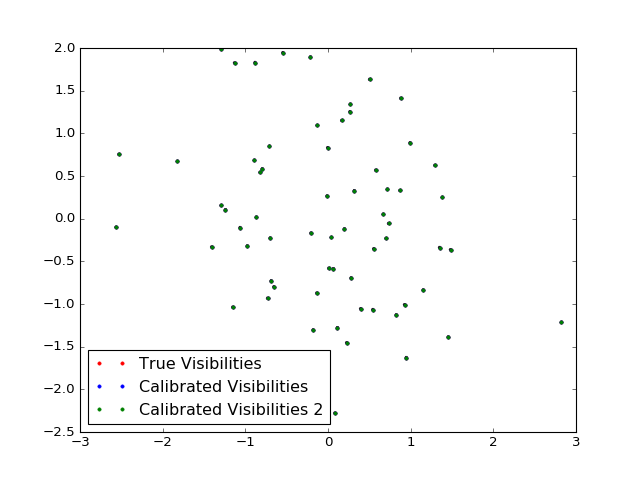

<IPython.core.display.Javascript object>


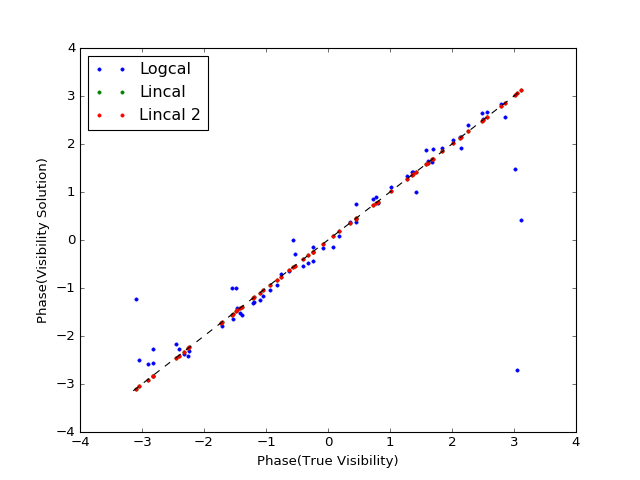

<IPython.core.display.Javascript object>


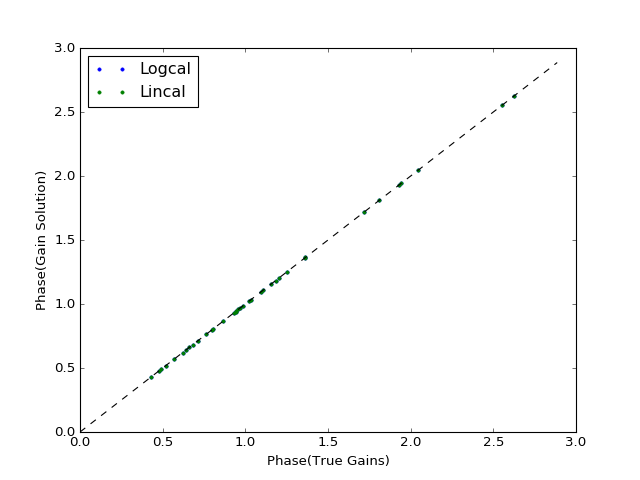

In [13]:
plt.figure()
plt.quiver(np.real(trueVis), np.imag(trueVis), np.real(visSols-trueVis), np.imag(visSols-trueVis),
           angles='xy', scale_units='xy', scale=1)
plt.plot(np.real(trueVis), np.imag(trueVis),'r.',label='True Visibilities')
plt.plot(np.real(visSols), np.imag(visSols),'b.',label='Calibrated Visibilities')
plt.plot(np.real(visSols2), np.imag(visSols2),'g.',label='Calibrated Visibilities 2')
plt.legend(loc='best')


plt.figure()
#plt.plot(np.abs(trueVis), np.abs(logcalVisSols))
plt.plot(np.angle(trueVis), np.angle(logcalVisSols),'.', label='Logcal')
plt.plot(np.angle(trueVis), np.angle(visSols),'.', label='Lincal')
plt.plot(np.angle(trueVis), np.angle(visSols2),'r.', label='Lincal 2')
plt.plot([-np.pi, np.pi], [-np.pi, np.pi], '--k')
plt.xlabel('Phase(True Visibility)'); plt.ylabel('Phase(Visibility Solution)')
plt.legend(loc='best')

plt.figure()
#plt.plot(np.abs(trueVis), np.abs(logcalVisSols))
plt.plot(np.abs(gains), np.abs(logcalGainSols),'.', label='Logcal')
plt.plot(np.abs(gains), np.abs(gainSols),'.', label='Lincal')
plt.xlabel('Phase(True Gains)'); plt.ylabel('Phase(Gain Solution)')
plt.plot([0, 1.1*np.max(np.abs(gains))], [0, 1.1*np.max(np.abs(gains))], '--k')
plt.legend(loc='best')

In [14]:
print 'Final Relative Error in Visibilities:', np.linalg.norm(visSols-trueVis) / np.linalg.norm(trueVis)
print 'Final Relative Error in Visibilities:', np.linalg.norm(visSols2-trueVis) / np.linalg.norm(trueVis)

Final Relative Error in Visibilities: 3.6542968803e-17
Final Relative Error in Visibilities: 4.15789902414e-16
